In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

tf.random.set_seed(42)


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=False, input_shape=input_shape))
    model.add(Dropout(0.2))
    # We use ReLU activation for non-linearity
    model.add(Dense(32, activation="relu"))
    model.add(
        Dense(2)
    )  # Predict next post count (scaled), 2 neurons for positive and negative
    # We use mean squared error (mse) as the loss function for regression
    model.compile(optimizer="adam", loss="mse")
    return model


def build_improved_lstm_model(input_shape):
    model = Sequential()
    # First LSTM layer with more units and return_sequences=True to allow stacking
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.3))  # Increased dropout for more regularization

    # Second LSTM layer to capture more complex temporal information
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))

    # Intermediate dense layer: we use ReLU to introduce non-linearity and BatchNormalization to stabilize learning
    model.add(Dense(64, activation="relu"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(Dropout(0.3))

    # Final layer: 2 neurons to predict counts (positive and negative)
    model.add(Dense(2))

    # We use mean squared error (mse) as the loss function for regression
    model.compile(optimizer="adam", loss="mse")
    return model

2025-05-26 10:39:15.565197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748248755.582183    7993 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748248755.587070    7993 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748248755.597985    7993 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748248755.598005    7993 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748248755.598006    7993 computation_placer.cc:177] computation placer alr

In [2]:
import pandas as pd
import numpy as np
from constants import SANREMO, HOUR_RANGES, NEXT_DAY_RANGES, SERATE
import os
from datetime import datetime, timedelta
from tabulate import tabulate
from utils import *


# Get all the data for the Sanremo festival untile the selected TIME_TO_PREDICT
TIME_TO_PREDICT = get_time_to_predict(SERATE[-1], "23:53:00")
print(f"Serata: {TIME_TO_PREDICT}")
# Load the data for the selected serata
dfs_to_load = load_data_night(
    SANREMO["NIGHTS"][TIME_TO_PREDICT["serata"]],
    TIME_TO_PREDICT["serata"],
    TIME_TO_PREDICT["datetime"],
    TIME_TO_PREDICT=TIME_TO_PREDICT,
)

# Aggregate data
dfs_aggregated = aggregate_data(dfs_to_load)

# Remove non-selected serate and hours
dfs_aggregated = clean_data(dfs_aggregated, TIME_TO_PREDICT=TIME_TO_PREDICT)

print_aggregated_data(dfs_aggregated, sort_by_positive=True)

# Get the training and validation data
X_train, X_val, y_train, y_val, artists_all, scalers, label_encoder = (
    prepare_lstm_data_with_labels(dfs_aggregated)
)

from tensorflow.keras.callbacks import EarlyStopping

# Build the LSTM model
#model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model = build_improved_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

early_stopping = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

# Train the model with validation data
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    verbose=1,
    callbacks=[early_stopping],
)

# Evaluate the model performance on the validation set
val_loss = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Loss: {val_loss}")

Serata: {'serata': 'Quinta serata', 'datetime': datetime.datetime(2025, 2, 15, 23, 53)}
--- Aggregazione per serata: Prima serata ---

Intervallo orario: Prima serata 21-22
+----------------------------+------------+------------+
| Artist                     |   Positive |   Negative |
|----------------------------+------------+------------|
| Simone Cristicchi          |         94 |          0 |
| Coma_Cose                  |         46 |          3 |
| Noemi Sanremo              |         40 |         12 |
| Marcella Bella             |         24 |         37 |
| Achille Lauro              |         12 |          0 |
| Gaia Sanremo               |         12 |          0 |
| Irama                      |         12 |          0 |
| Francesco Gabbani          |          0 |         19 |
| Willie Peyote              |          0 |          0 |
| Rkomi                      |          0 |         19 |
| Moda Sanremo               |          0 |          0 |
| Rose Villain               

2025-05-26 10:39:19.243297: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/enrico/Desktop/EP_Sanremo/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,026 (472.76 KB)

 Trainable params: 120,898 (472.26 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.1266 - val_loss: 0.0598
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0978 - val_loss: 0.0605
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0939 - val_loss: 0.0607
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0895 - val_loss: 0.0602
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0932 - val_loss: 0.0599
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0935 - val_loss: 0.0602
Validation Loss: 0.059805579483509064


In [3]:
# Calculate predictions for the next post counts
predictions = get_predictions(model, dfs_aggregated, scalers, label_encoder, verbose=False)

# Print predictions sorted by total posts (positive + negative)
print("Next post count predictions (sorted by total posts):")
for artist, counts in sorted(
    predictions.items(), key=lambda x: x[1]["positive"] - x[1]["negative"], reverse=True
):
    total = counts["positive"] - counts["negative"]
    print(f"{artist}: total {total:.0f} (+{counts['positive']:.0f}, -{counts['negative']:.0f})")


Next post count predictions (sorted by total posts):
Brunori Sas: total 16 (+17, -2)
Olly: total 15 (+17, -1)
Lucio Corsi: total 15 (+16, -2)
Fedez: total 15 (+15, -1)
Irama: total 12 (+14, -2)
Achille Lauro: total 11 (+12, -0)
Bresh: total 11 (+13, -2)
Giorgia Sanremo: total 11 (+11, -1)
Coma_Cose: total 10 (+13, -2)
Rocco Hunt: total 10 (+13, -3)
Rose Villain: total 9 (+12, -2)
Simone Cristicchi: total 9 (+11, -2)
Tony Effe: total 9 (+11, -2)
Serena Brancale: total 9 (+9, -0)
The Kolors: total 7 (+12, -5)
Elodie: total 6 (+11, -5)
Shablo Gue Joshua Tormento: total 6 (+6, -0)
Sarah Toscano: total 5 (+8, -3)
Moda Sanremo: total 5 (+5, -0)
Francesco Gabbani: total 5 (+7, -2)
Francesca Michielin: total 5 (+9, -4)
Willie Peyote: total 4 (+9, -5)
Massimo Ranieri: total 4 (+6, -2)
Noemi Sanremo: total 4 (+5, -1)
Rkomi: total 4 (+8, -5)
Clara Sanremo: total 3 (+3, -0)
Joan Thiele: total 1 (+5, -3)
Gaia Sanremo: total 1 (+1, -0)
Marcella Bella: total 1 (+5, -4)


/tmp/ipykernel_7993/676584092.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  COLOR_PALETTE = plt.cm.get_cmap("tab20")


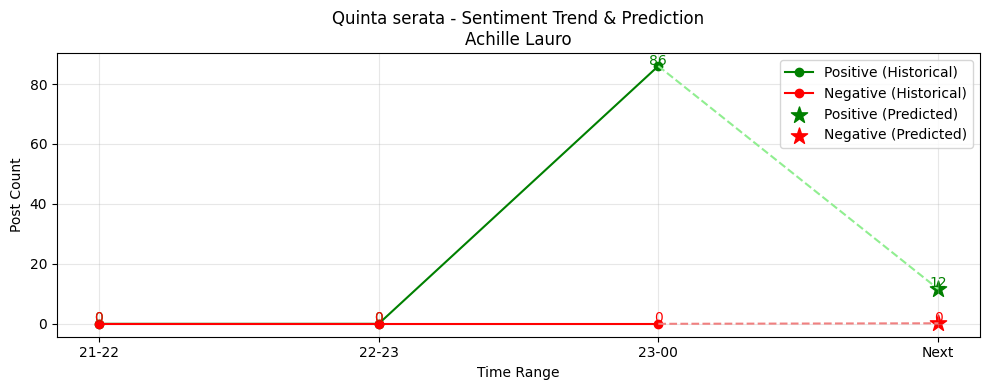

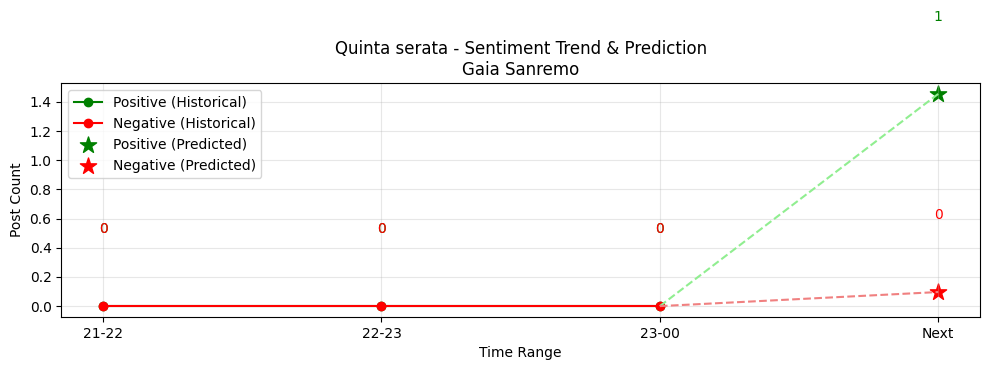

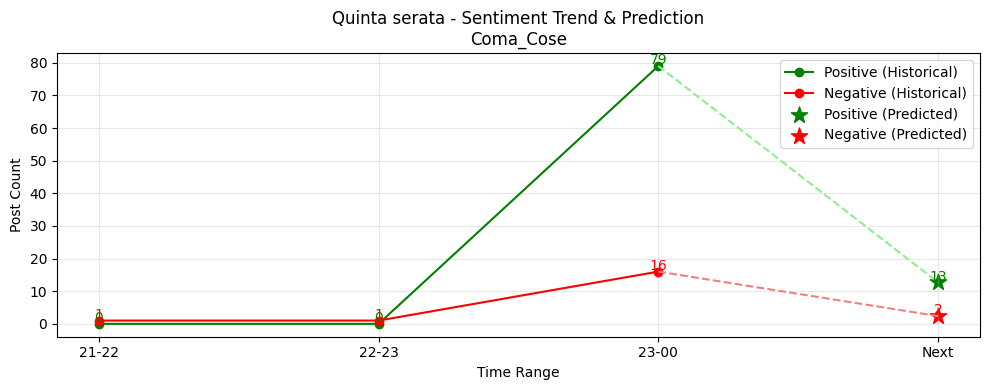

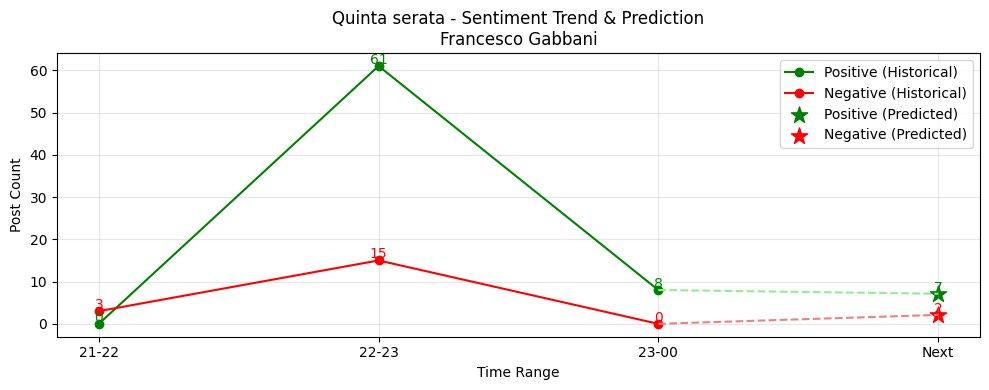

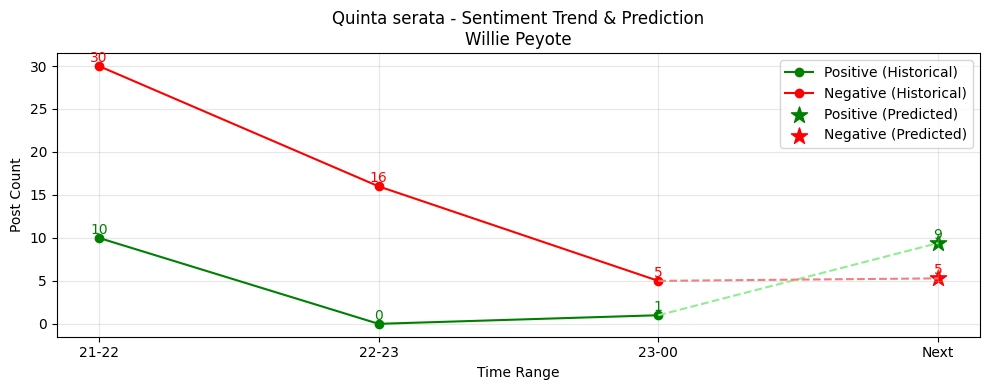

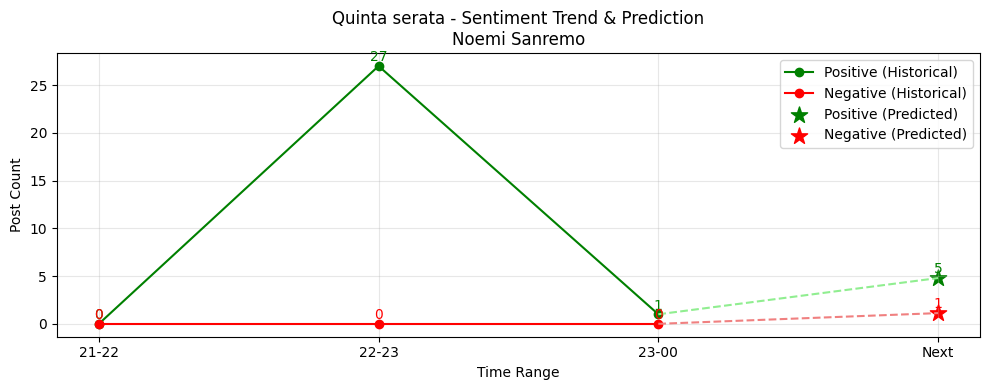

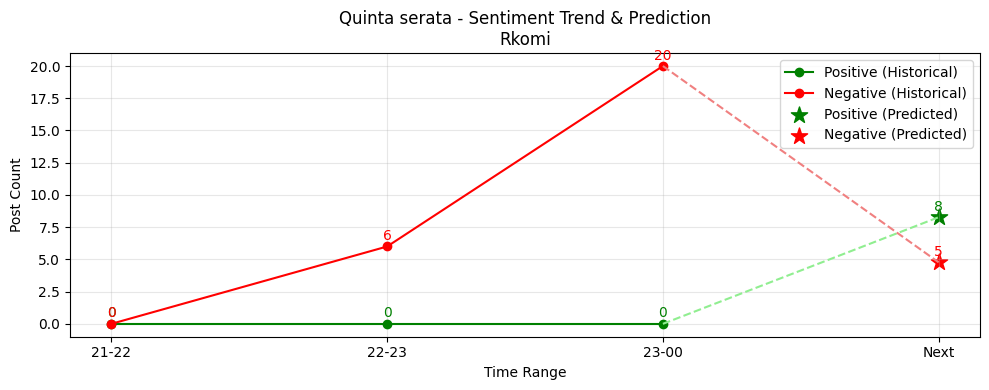

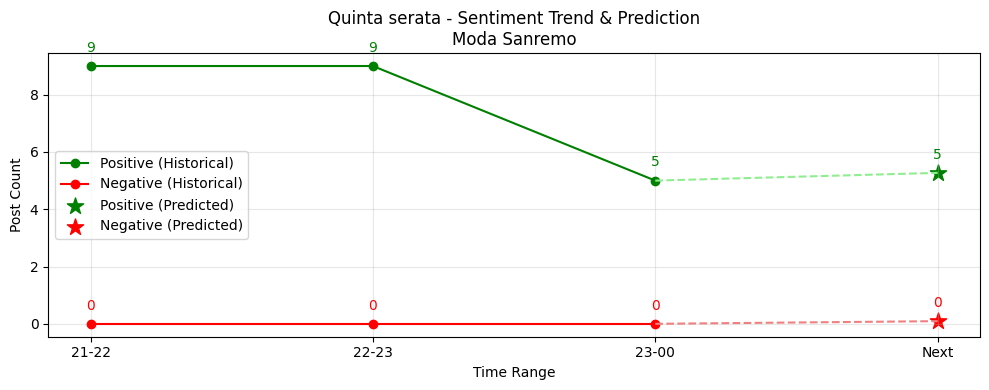

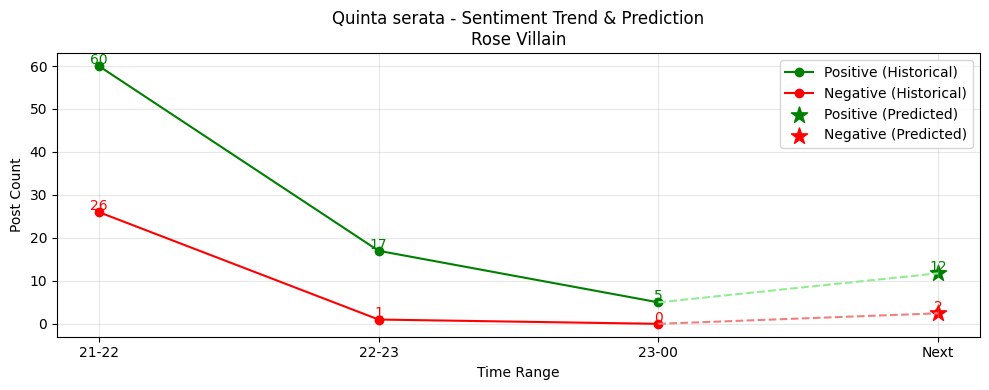

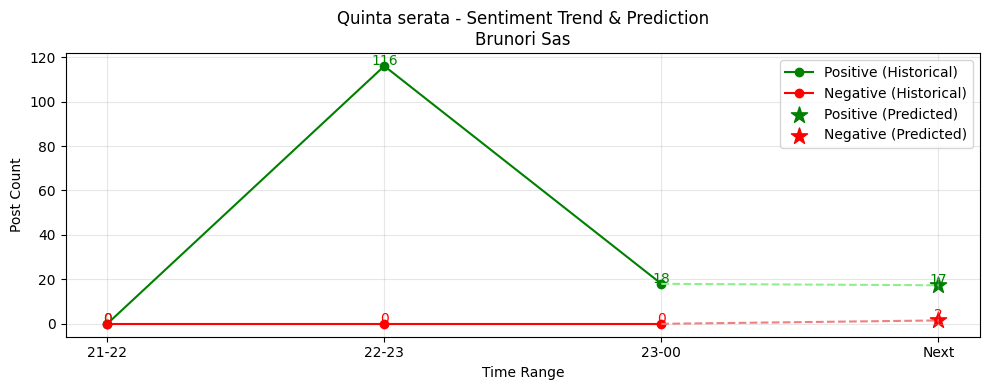

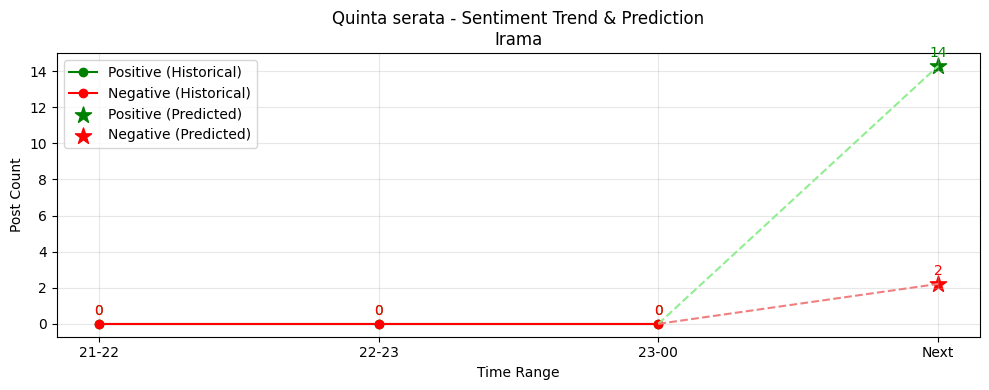

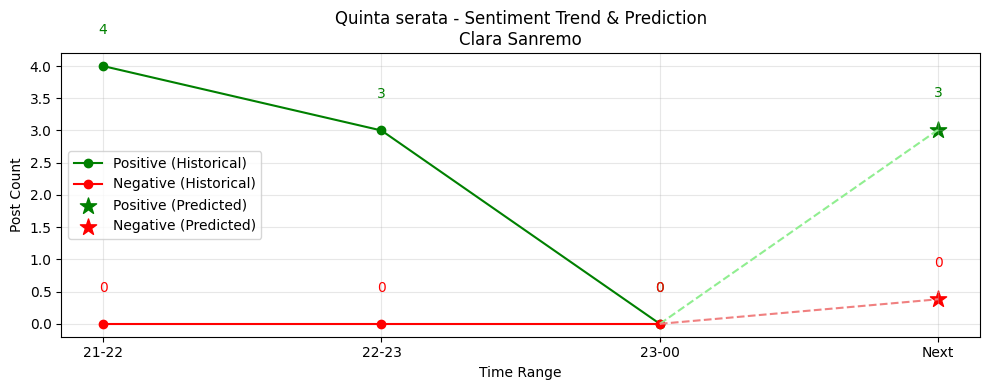

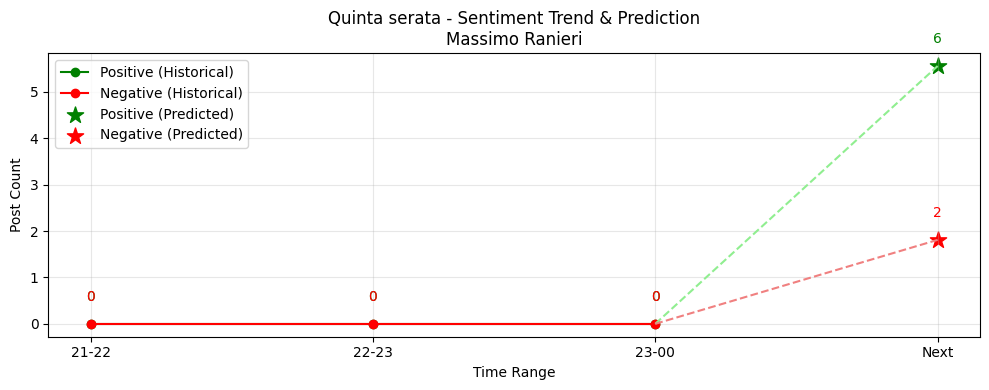

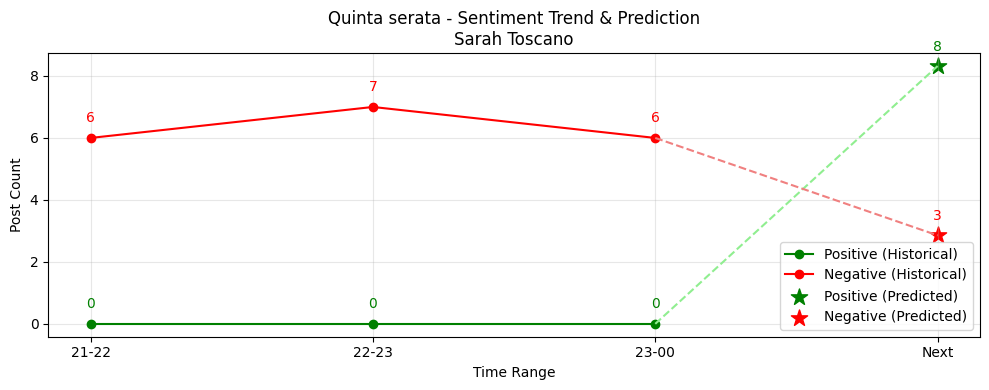

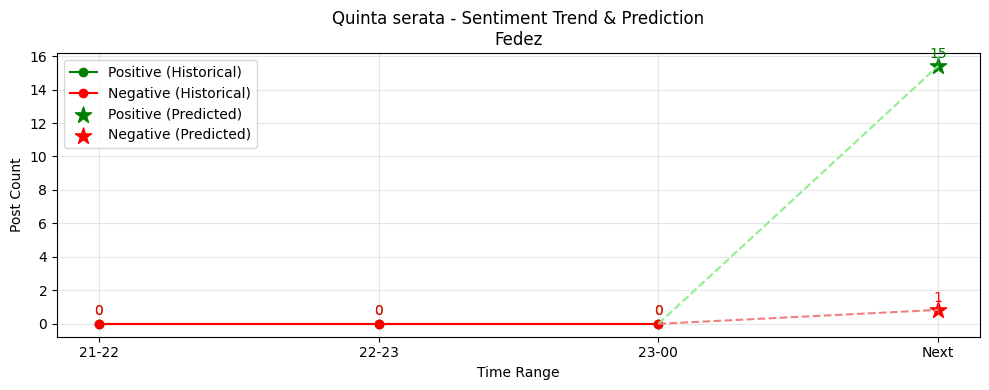

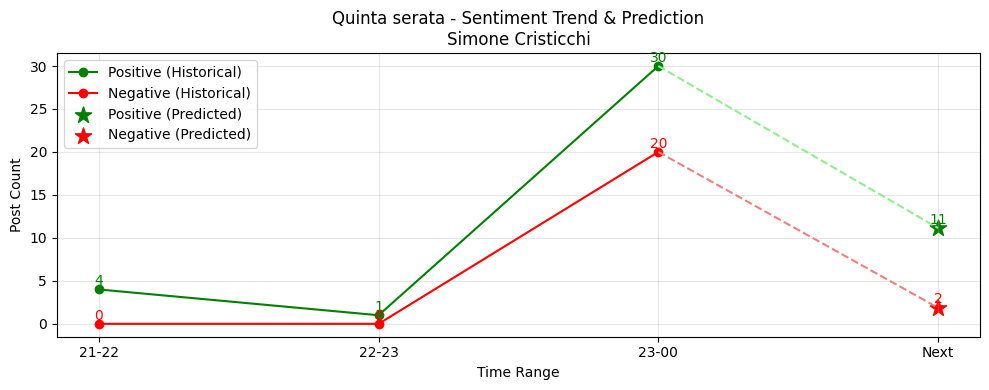

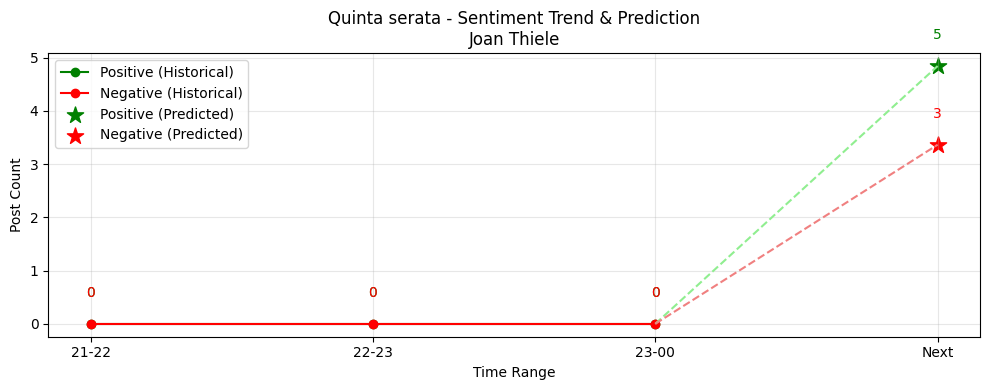

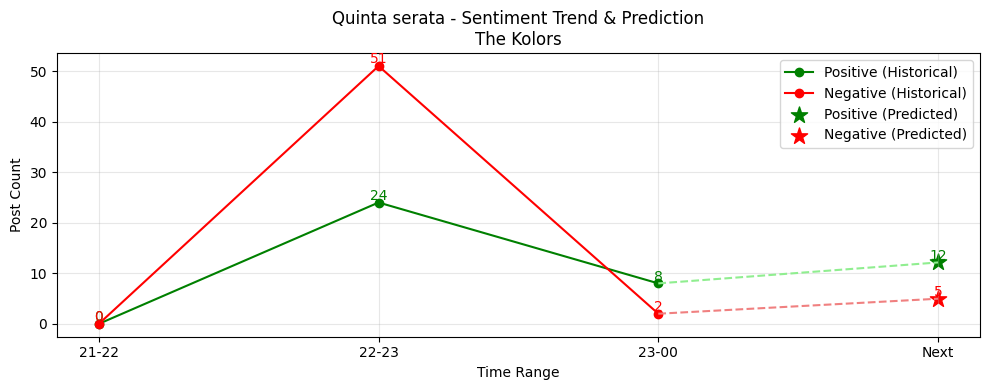

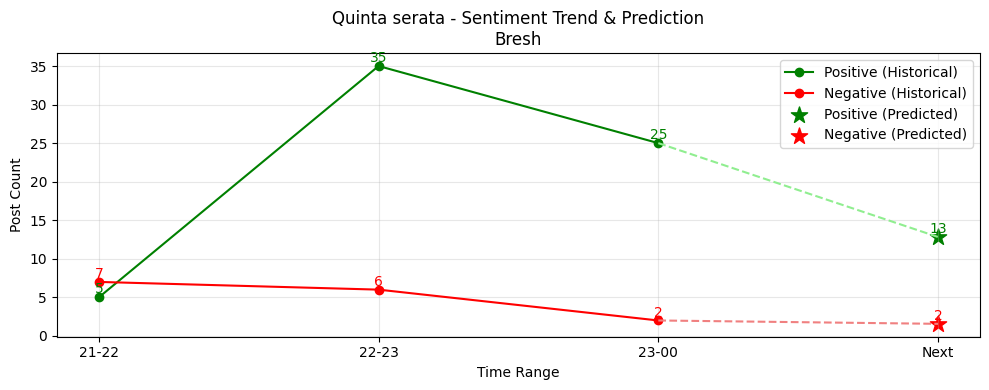

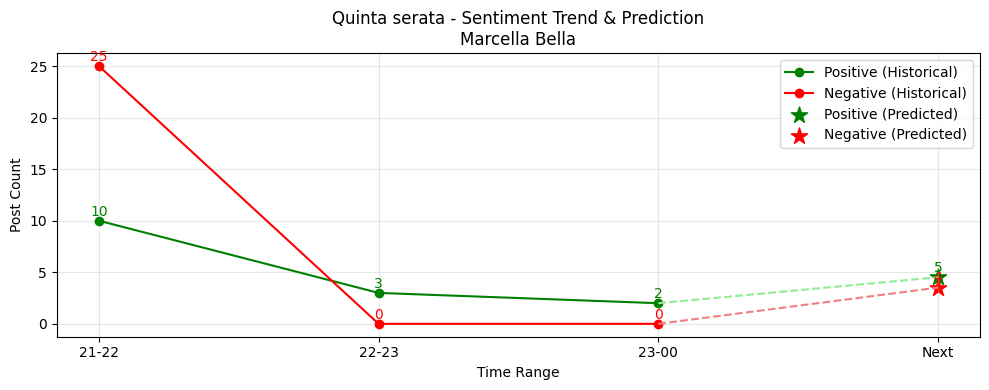

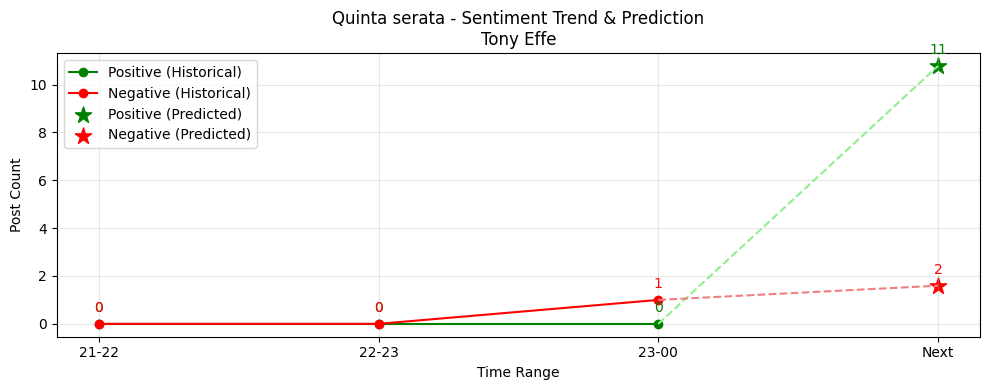

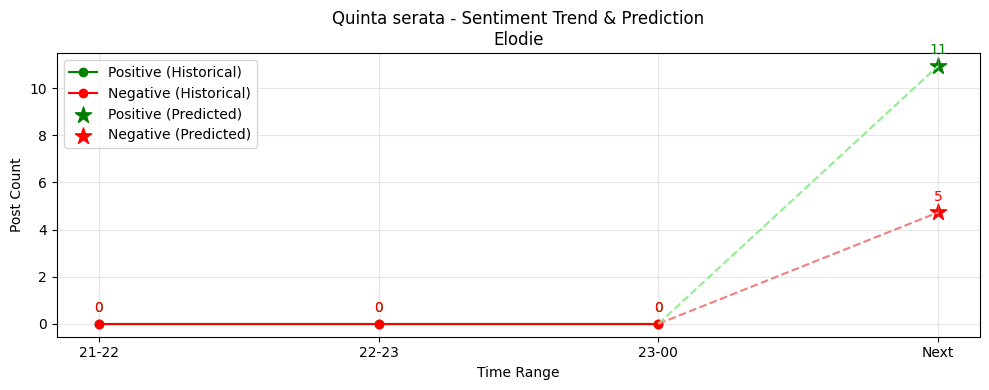

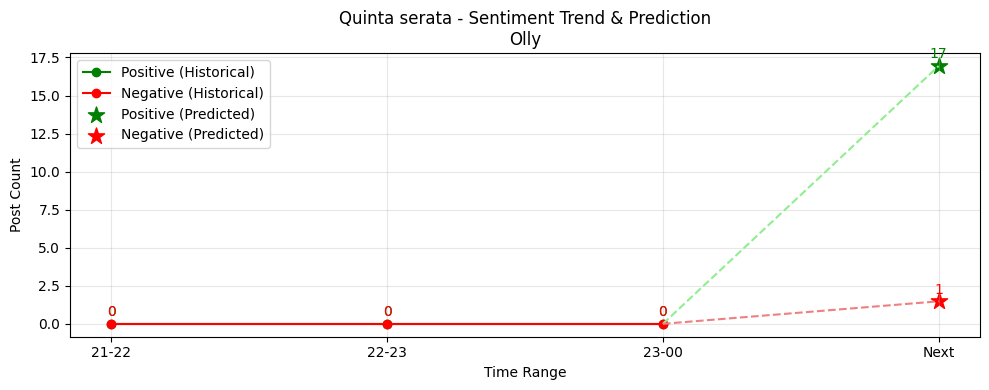

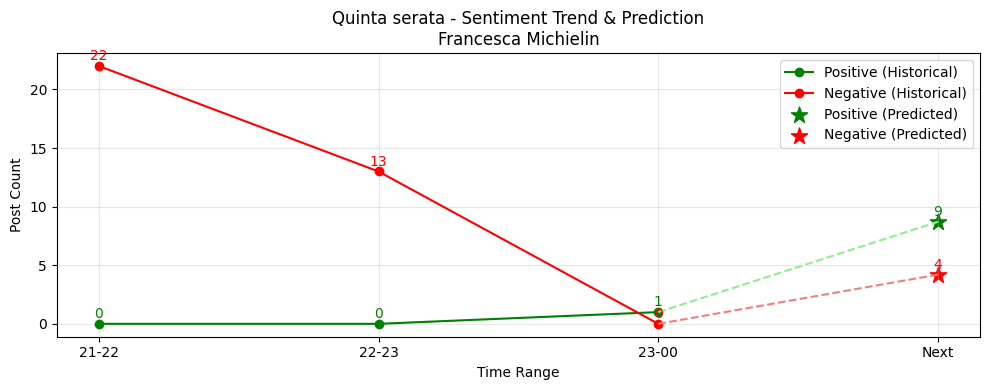

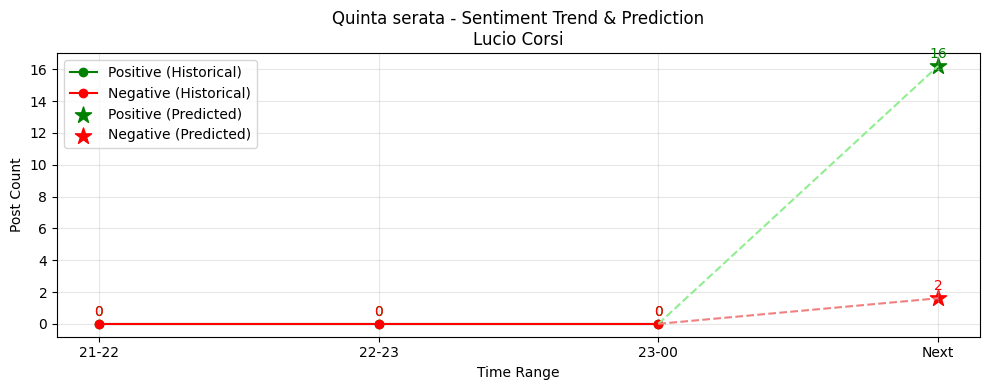

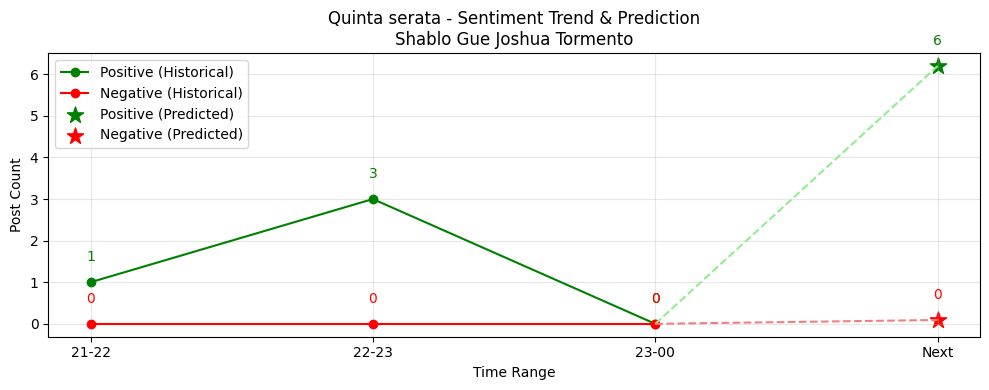

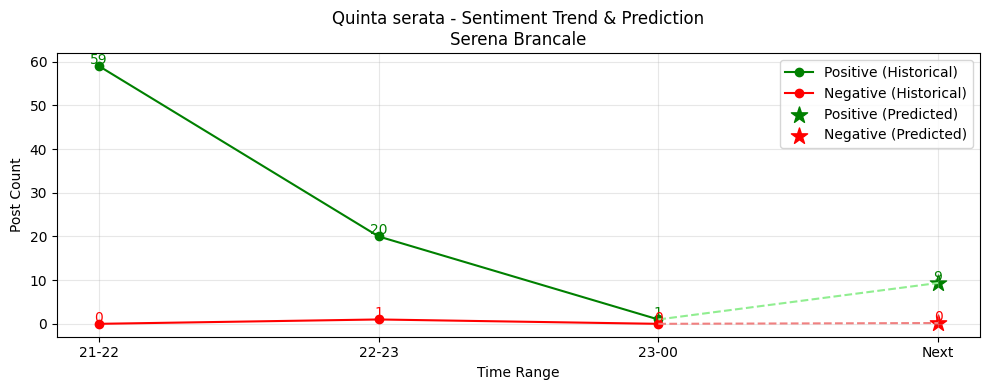

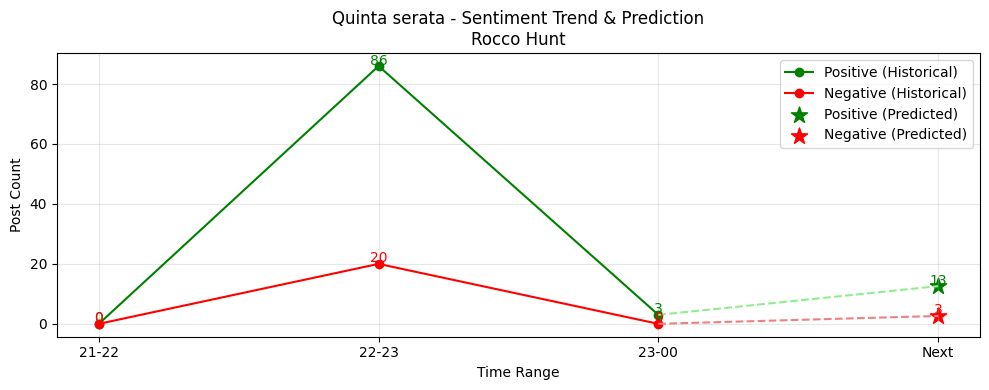

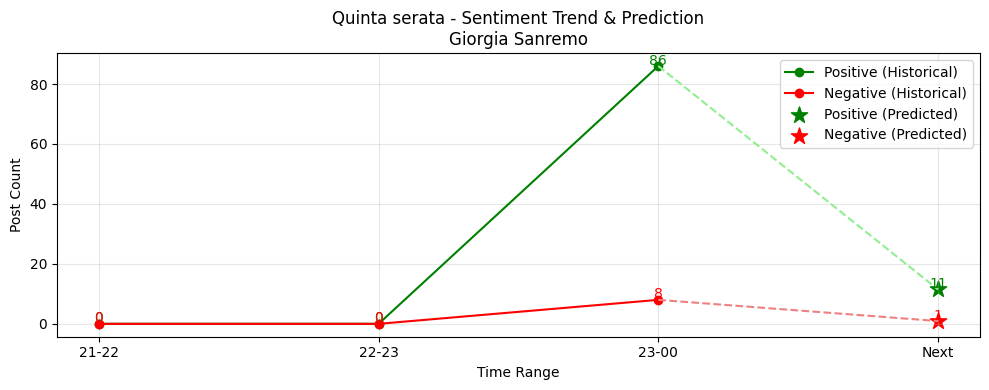

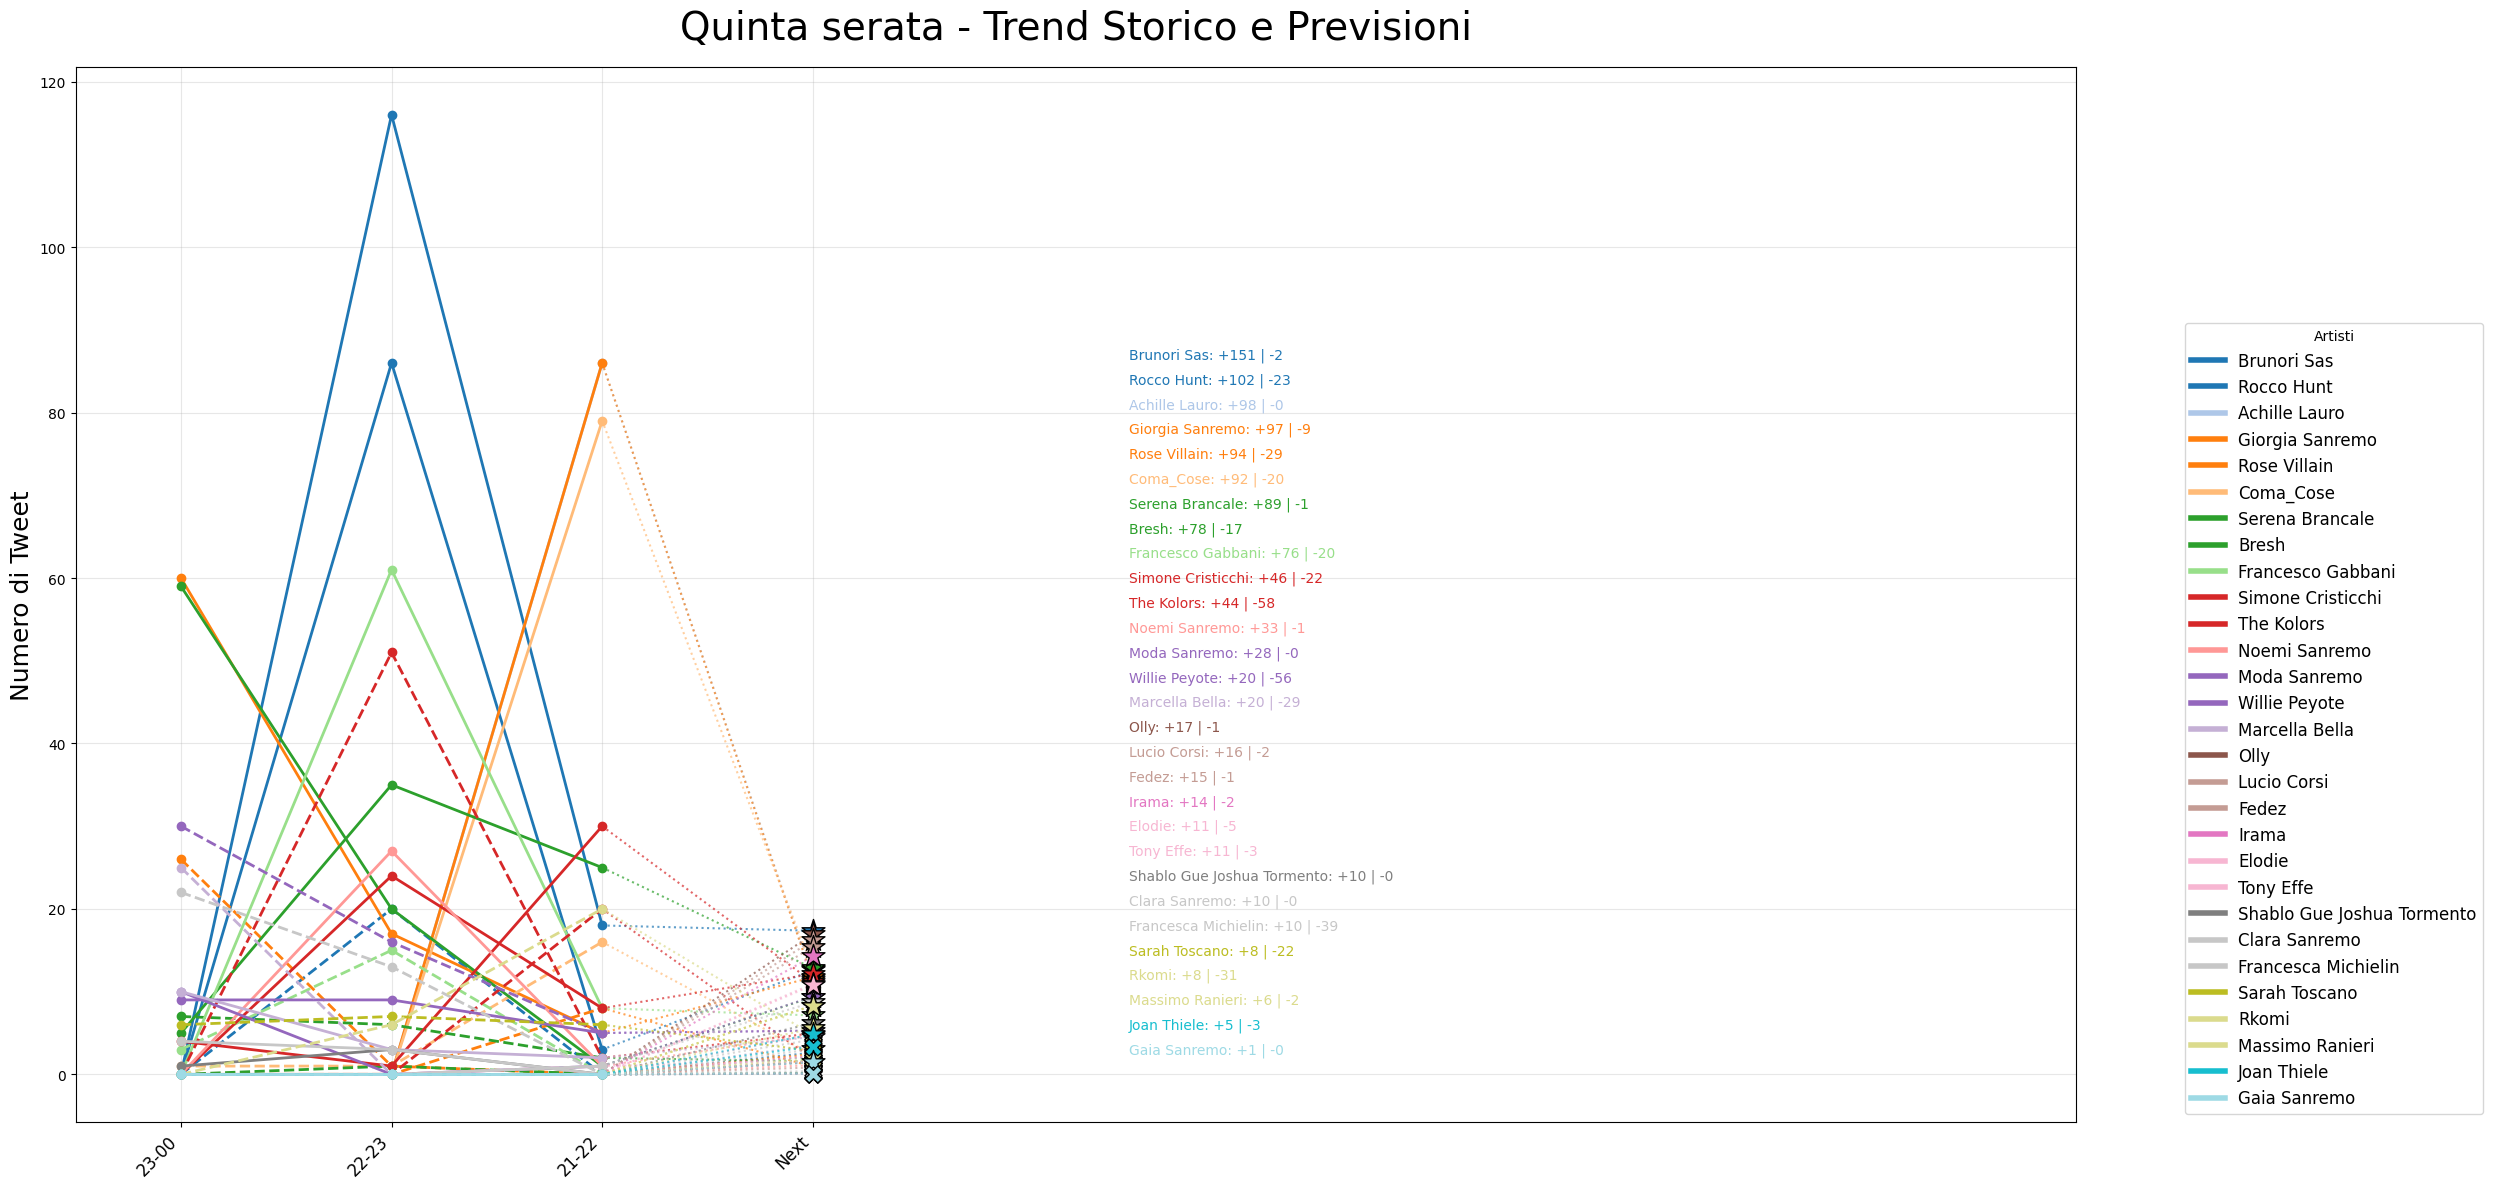

In [4]:
import matplotlib.pyplot as plt

PLOT_SAVE_PATH = "predictions"
COLOR_PALETTE = plt.cm.get_cmap("tab20")


def plot_artist_prediction(
    artist,
    historical_pos,
    historical_neg,
    pred_pos,
    pred_neg,
    hour_ranges,
    night_name,
    PLOT_SAVE_PATH="predictions",
):
    """Plot historical hourly counts and prediction for a single artist"""
    plt.figure(figsize=(10, 4))

    # Create extended hour range including prediction
    extended_hours = hour_ranges + ["Next"]
    x_historical = np.arange(len(hour_ranges))
    x_pred = len(hour_ranges)  # Position for prediction

    # Plot historical data
    plt.plot(x_historical, historical_pos, "g-o", label="Positive (Historical)")
    plt.plot(x_historical, historical_neg, "r-o", label="Negative (Historical)")

    # Plot predictions
    plt.scatter(
        x_pred, pred_pos, s=150, c="green", marker="*", label="Positive (Predicted)"
    )
    plt.scatter(
        x_pred, pred_neg, s=150, c="red", marker="*", label="Negative (Predicted)"
    )

    # Add labels and title
    plt.title(f"{night_name} - Sentiment Trend & Prediction\n{artist}")
    plt.xlabel("Time Range")
    plt.ylabel("Post Count")
    plt.xticks(np.arange(len(extended_hours)), extended_hours)
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add value labels
    for i, (pos, neg) in enumerate(
        zip(historical_pos + [pred_pos], historical_neg + [pred_neg])
    ):
        plt.text(i, pos + 0.5, f"{pos:.0f}", ha="center", color="green")
        plt.text(i, neg + 0.5, f"{neg:.0f}", ha="center", color="red")

    # Add dashed lines for prediction trend
    plt.plot(
        [x_historical[-1], x_pred],
        [historical_pos[-1], pred_pos],
        color="lightgreen",
        linestyle="--",
        label="Positive (Prediction trend)",
    )
    plt.plot(
        [x_historical[-1], x_pred],
        [historical_neg[-1], pred_neg],
        color="lightcoral",
        linestyle="--",
        label="Negative (Prediction trend)",
    )

    plt.tight_layout()

    # Save and show
    os.makedirs(f"{PLOT_SAVE_PATH}", exist_ok=True)
    plt.savefig(f"{PLOT_SAVE_PATH}/{artist.replace(' ', '_')}_prediction.png")
    plt.show()


def plot_combined_prediction(artist_data, all_hour_labels):
    """Crea grafico combinato con predizioni per tutti gli artisti"""
    fig, ax = plt.subplots(figsize=(25, 12))

    # Data preparation
    extended_hours = list(all_hour_labels) + ["Next"]
    x_historical = np.arange(len(all_hour_labels))
    x_pred = len(all_hour_labels)

    # Sort artists by total posts (historical + predicted)
    sorted_artists = sorted(
        artist_data.keys(),
        key=lambda a: sum(artist_data[a]["historical_pos"])
        + artist_data[a]["pred_pos"],
        reverse=True,
    )

    # Plot data for each artist
    for idx, artist in enumerate(sorted_artists):
        data = artist_data[artist]
        color = COLOR_PALETTE(idx / len(sorted_artists))

        # Historical lines
        ax.plot(
            x_historical,
            data["historical_pos"],
            color=color,
            linestyle="-",
            marker="o",
            linewidth=2,
        )
        ax.plot(
            x_historical,
            data["historical_neg"],
            color=color,
            linestyle="--",
            marker="o",
            linewidth=2,
        )

        # Prediction points
        ax.scatter(
            x_pred,
            data["pred_pos"],
            color=color,
            marker="*",
            s=300,
            edgecolor="black",
            zorder=10,
        )
        ax.scatter(
            x_pred,
            data["pred_neg"],
            color=color,
            marker="X",
            s=150,
            edgecolor="black",
            zorder=10,
        )

        # Dashed lines for prediction trend
        ax.plot(
            [x_historical[-1], x_pred],
            [data["historical_pos"][-1], data["pred_pos"]],
            color=color,
            linestyle=":",
            alpha=0.7,
        )
        ax.plot(
            [x_historical[-1], x_pred],
            [data["historical_neg"][-1], data["pred_neg"]],
            color=color,
            linestyle=":",
            alpha=0.7,
        )

    # Axis setup
    ax.set_xticks(np.arange(len(extended_hours)))
    ax.set_xticklabels(extended_hours, rotation=45, ha="right", fontsize=12)
    ax.set_xlim(-0.5, len(extended_hours) - 0.5)

    # Add totals for each artist on the right side
    for i, artist in enumerate(sorted_artists):
        data = artist_data[artist]
        tot_pos = sum(data["historical_pos"]) + data["pred_pos"]
        tot_neg = sum(data["historical_neg"]) + data["pred_neg"]

        ax.text(
            len(extended_hours) + 0.5,
            (len(sorted_artists) - i) * 3,  # Adjust vertical position
            f"{artist}: +{tot_pos:.0f} | -{tot_neg:.0f}",
            color=COLOR_PALETTE(i / len(sorted_artists)),
            va="center",
        )

    # Second legend for artists with colors
    artist_legend = [
        plt.Line2D(
            [0], [0], color=COLOR_PALETTE(i / len(sorted_artists)), lw=4, label=artist
        )
        for i, artist in enumerate(sorted_artists)
    ]

    ax.legend(
        handles=artist_legend,
        loc="lower left",
        bbox_to_anchor=(1.05, 0),
        fontsize=12,
        title="Artisti",
    )

    # Title and labels
    ax.set_title(
        f"{TIME_TO_PREDICT['serata']} - Trend Storico e Previsioni", fontsize=28, pad=20
    )
    ax.set_ylabel("Numero di Tweet", fontsize=18)
    ax.grid(True, alpha=0.3)

    plt.xlim(-0.5, len(extended_hours) + 5)
    plt.tight_layout()
    plt.savefig(f"{PLOT_SAVE_PATH}/COMBINED_PREDICTION.png", bbox_inches="tight")
    plt.show()


artist_data = {}
all_hour_labels = set()

for artist, counts in predictions.items():
    historical_pos = []
    historical_neg = []
    used_hours = []

    # Get historical data for the artist
    for hr in HOUR_RANGES:
        # Consider only the current night (e.g. TIME_TO_PREDICT["serata"])
        serata_data = dfs_aggregated.get(TIME_TO_PREDICT["serata"], {})
        if hr in serata_data and artist in serata_data[hr]:
            historical_pos.append(serata_data[hr][artist]["positive_count"])
            historical_neg.append(serata_data[hr][artist]["negative_count"])
            used_hours.append(hr)

    pred_pos = counts["positive"]
    pred_neg = counts["negative"]

    artist_data[artist] = {
        "historical_pos": historical_pos,
        "historical_neg": historical_neg,
        "pred_pos": pred_pos,
        "pred_neg": pred_neg,
    }

    all_hour_labels.update(used_hours)

    plot_artist_prediction(
        artist=artist,
        historical_pos=historical_pos,
        historical_neg=historical_neg,
        pred_pos=pred_pos,
        pred_neg=pred_neg,
        hour_ranges=used_hours,
        night_name=TIME_TO_PREDICT["serata"],
    )

plot_combined_prediction(artist_data, all_hour_labels)